In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 8)

import warnings
warnings.filterwarnings('ignore')

!date

Mon Jul  8 14:05:10 PDT 2019


In [2]:
result_dir = '/share/costeffectiveness/results/sqlns/'

In [3]:
path_for_location = {'Bangladesh': result_dir + 'bangladesh/2019_06_23_13_00_56',
                     'Burkina Faso': result_dir + 'burkina_faso/2019_06_23_13_08_05',
                     'Ethiopia': result_dir + 'ethiopia/2019_06_23_13_13_25',
                     'India': result_dir + 'india/2019_06_23_13_17_02',
                     'Nigeria': result_dir + 'nigeria/2019_06_23_13_20_57'}

cause_names = ['lower_respiratory_infections', 'measles', 'diarrheal_diseases', 'protein_energy_malnutrition', 'iron_deficiency', 'other_causes']
risk_names = ['anemia', 'child_stunting', 'child_wasting']

template_cols = ['coverage', 'cause', 'measure', 'input_draw']

In [4]:
def clean_and_aggregate(path):
    r = pd.read_hdf(path + '/output.hdf')
    r.rename(columns={'sqlns.program_coverage': 'coverage'}, inplace=True)
    r['coverage'] *= 100
    r = r.groupby(['coverage', 'input_draw']).sum()
    return r

In [5]:
def standardize_shape(data, measure):
    measure_data = data.loc[:, [c for c in data.columns if measure in c]]
    measure_data = measure_data.stack().reset_index().rename(columns={'level_2': 'label', 0: 'value'})
    if 'due_to' in measure:
        measure, cause = measure.split('_due_to_', 1)
        measure_data.loc[:, 'measure'] = measure
        measure_data.loc[:, 'cause'] = cause
    else:
        measure_data.loc[:, 'measure'] = measure  
    measure_data.drop(columns='label', inplace=True)
    
    return measure_data

In [6]:
def get_person_time(data):
    pt = standardize_shape(data, 'person_time')
    pt = pt.rename(columns={'value': 'person_time'}).drop(columns='measure')
    return pt

In [7]:
def get_disaggregated_results(data, cause_names):
    deaths = []
    ylls = []
    ylds = []
    dalys = []
    for cause in cause_names:
        if cause in cause_names[:4]:
            deaths.append(standardize_shape(data, f'death_due_to_{cause}'))
            
            ylls_sub = standardize_shape(data, f'ylls_due_to_{cause}')
            ylds_sub = standardize_shape(data, f'ylds_due_to_{cause}')
            dalys_sub = (ylds_sub.set_index([c for c in template_cols if c != 'measure']) + \
                         ylls_sub.set_index([c for c in template_cols if c != 'measure'])).reset_index()
            dalys_sub['measure'] = 'dalys'
            
            ylls.append(ylls_sub)
            ylds.append(ylds_sub)
            dalys.append(dalys_sub)
        elif cause == 'iron_deficiency':
            ylds_sub = standardize_shape(data, f'ylds_due_to_{cause}')     
            dalys_sub = ylds_sub.copy()
            dalys_sub['measure'] = 'dalys'
            
            ylds.append(ylds_sub)
            dalys.append(dalys_sub)
        else: # cause == 'other_causes'
            deaths.append(standardize_shape(data, f'death_due_to_{cause}'))
            
            ylls_sub = standardize_shape(data, f'ylls_due_to_{cause}')
            dalys_sub = ylls_sub.copy()
            dalys_sub['measure'] = 'dalys'
            
            ylls.append(ylls_sub)
            dalys.append(dalys_sub)
    
    death_data = pd.concat(deaths)
    yll_data = pd.concat(ylls)
    yld_data = pd.concat(ylds)
    daly_data = pd.concat(dalys)
    
    output = pd.concat([death_data, yll_data, yld_data, daly_data])
    output = output.set_index(template_cols).sort_index()
    
    return output.reset_index()

In [8]:
def get_averted_results(df):
    bau = df[df.coverage == 0.0].drop(columns=['coverage', 'person_time'])
    t = pd.merge(df, bau, on =['cause', 'measure', 'input_draw'], suffixes=['', '_bau'])
    t['averted'] = t['value_bau'] - t['value']
    t.drop(columns='value_bau', inplace=True)
    
    t['value'] = (t['value']/t['person_time']) * 100_000
    t['averted'] = (t['averted']/t['person_time']) * 100_000
    
    return t

In [9]:
def get_all_causes_dalys_averted(df):
    cols = ['coverage', 'input_draw', 'years_lived_with_disability', 'years_of_life_lost', 'person_time']
    data = df[cols]
    data['value'] = data['years_lived_with_disability'] + data['years_of_life_lost']
    data.drop(columns=['years_lived_with_disability', 'years_of_life_lost'], inplace=True)
    
    bau = data.loc[data.coverage == 0.0, ['input_draw', 'value']]
    t = pd.merge(data, bau, on ='input_draw', suffixes=['', '_bau'])
    t['averted'] = t['value_bau'] - t['value']
    t.drop(columns='value_bau', inplace=True)
    
    t['value'] = (t['value']/t['person_time']) * 100_000
    t['averted'] = (t['averted']/t['person_time']) * 100_000
    
    t['cause'] = 'all_causes'
    t['measure'] = 'dalys'
    
    return t

In [10]:
def get_all_causes_mortality_reduction(df):
    cols = ['coverage', 'input_draw', 'total_population_dead']
    data = df[cols]
    bau = data.loc[data.coverage == 0.0, ['input_draw', 'total_population_dead']]
    t = pd.merge(data, bau, on ='input_draw', suffixes=['', '_bau'])
    
    t['averted'] = t['total_population_dead_bau'] - t['total_population_dead']
    t['averted'] = t['averted']/t['total_population_dead_bau']
    
    t.drop(columns=['total_population_dead', 'total_population_dead_bau'], inplace=True)
    t['cause'] = 'all_causes'
    t['measure'] = 'death'
    
    return t

In [11]:
def get_final_table(data):
    g = data.groupby(['cause', 'coverage', 'measure'])[['person_time', 'value', 'averted']]\
            .describe(percentiles=[.025, .975])
    
    table = g.filter([('value', 'mean'), ('value', '2.5%'), ('value', '97.5%'),
                      ('person_time', 'mean'), ('person_time', '2.5%'), ('person_time', '97.5%'),
                      ('averted', 'mean'), ('averted', '2.5%'), ('averted', '97.5%')])
    return table

In [12]:
def plot_dalys_averted(df, cause_names, location):
    data = df.query('measure == "dalys"')[[('averted', 'mean'), ('averted', '2.5%'), ('averted', '97.5%')]]\
             .reset_index()
    
    plt.figure(figsize=(12, 8))
    
    for cause in cause_names + ['all_causes']:
        data_sub = data.loc[data.cause == cause]
        
        xx = data_sub['coverage']
        mean = data_sub[('averted', 'mean')]
        lb = data_sub[('averted', '2.5%')]
        ub = data_sub[('averted', '97.5%')]
        
        plt.plot(xx, mean, '-o', label=cause)
        plt.fill_between(xx, lb, ub, alpha=0.1)
    
    plt.title(location)
    plt.xlabel('Program Coverage (%)')
    plt.ylabel('DALYs Averted (per100,000PY)')
    plt.legend(loc=(1.05, .05))
    plt.grid()
    
    plt.savefig(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/sqlns_DALYs_averted_in_{location}.pdf', bbox_inches='tight')
    plt.savefig(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/sqlns_DALYs_averted_in_{location}.png', bbox_inches='tight')

# DALYs Averted per 100,000 PY by Coverage and Causes

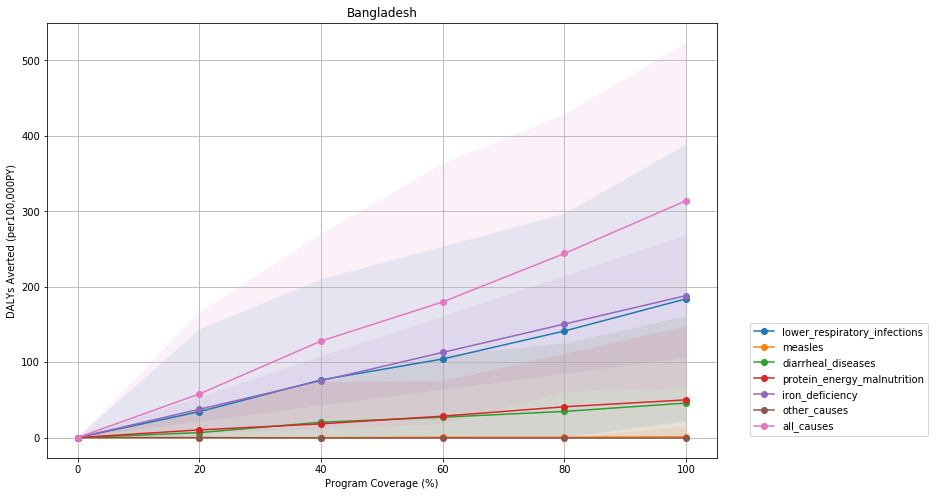

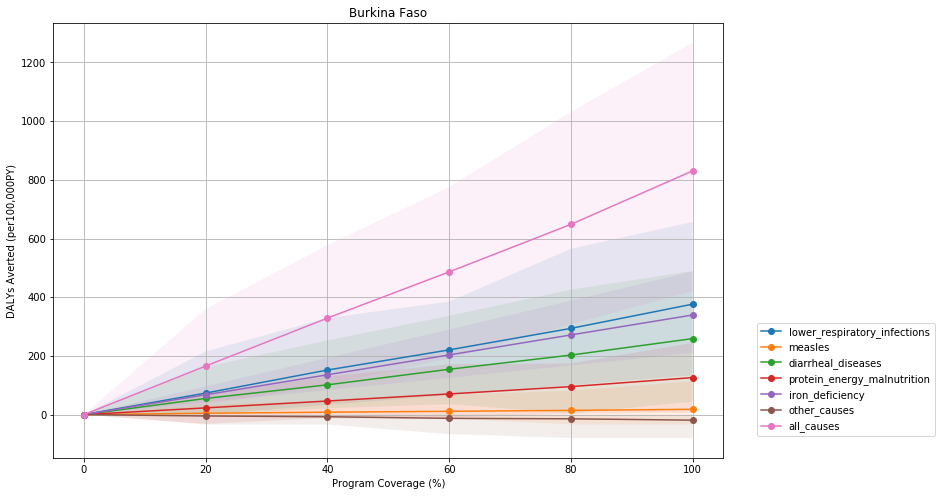

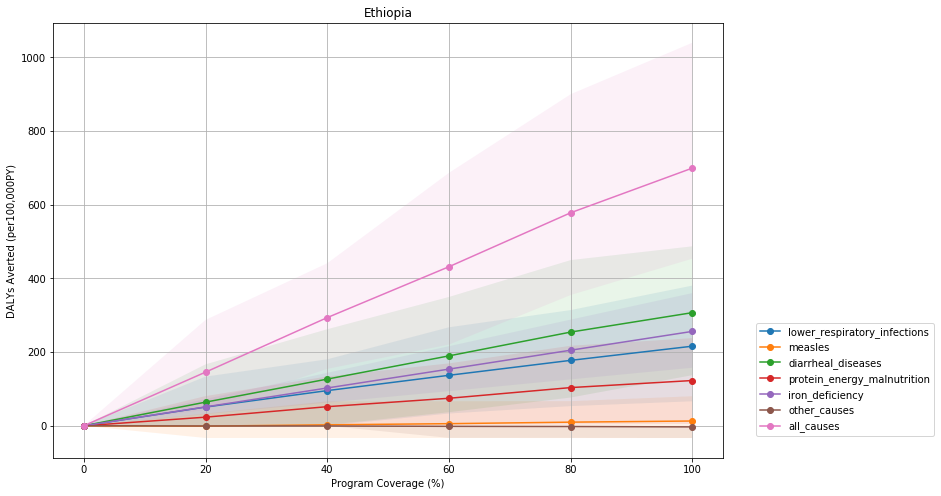

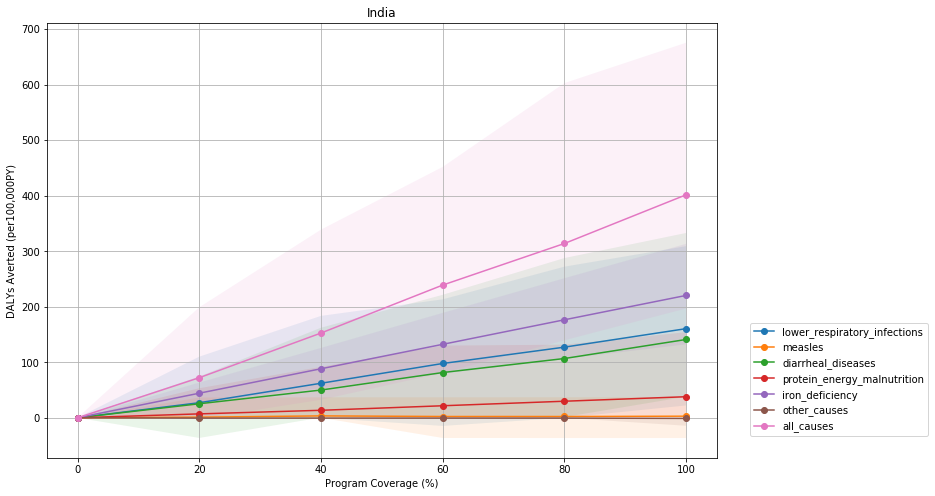

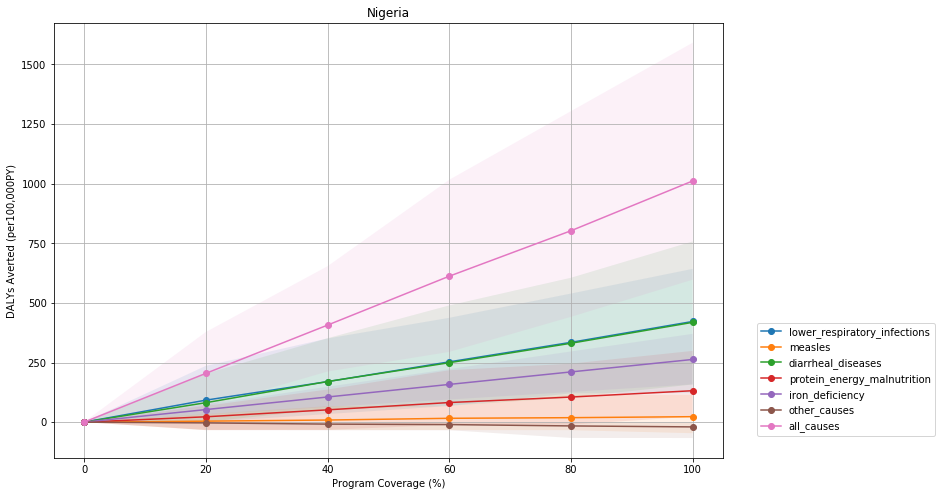

In [13]:
for location, path in path_for_location.items():    
    
    r = clean_and_aggregate(path)
    person_time = get_person_time(r)
    output = get_disaggregated_results(r, cause_names)
    df = pd.merge(output, person_time, on=['coverage', 'input_draw'])
    df_full = pd.concat([get_averted_results(df), get_all_causes_dalys_averted(r.reset_index())])
    t = get_final_table(df_full)
    
    plot_dalys_averted(t, cause_names, location)

# All Causes, DALYs Averted per 100,000 PY OR Mortality reduction rate by Location and Coverage

In [14]:
def get_all_causes_results(my_dict, measure):
    results = []
    for location, path in my_dict.items():
        df = clean_and_aggregate(path).reset_index()
        if measure == 'dalys_averted_rate':
            t = get_all_causes_dalys_averted(df)
        if measure == 'mortality_reduction_rate':
            t = get_all_causes_mortality_reduction(df)
        t['location'] = location
        results.append(t)
    data = pd.concat(results)
    g = data.groupby(['location', 'coverage'])['averted'].describe(percentiles=[.025, .975])\
            .filter(['mean', '2.5%', '97.5%'])
    return g.reset_index()

In [15]:
all_causes_dalys_averted_rate = get_all_causes_results(path_for_location, 'dalys_averted_rate')
all_causes_dalys_averted_rate.pivot(index='location', columns='coverage').to_csv('/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/all_causes_dalys_averted.csv')

In [16]:
all_causes_mortality_reduction_rate = get_all_causes_results(path_for_location, 'mortality_reduction_rate')
all_causes_mortality_reduction_rate.pivot(index='location', columns='coverage').to_csv('/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/all_causes_mortality_reduction.csv')

In [17]:
def plot_all_causes_mortality_reduction(df):

    plt.figure(figsize=(12, 8))
    
    for location in df.location.unique():
        df_sub = df.loc[df.location == location]
        
        xx = df_sub['coverage']
        mean = df_sub['mean']
        lb = df_sub['2.5%']
        ub = df_sub['97.5%']
        
        plt.plot(xx, mean, '-o', label=location)
        plt.fill_between(xx, lb, ub, alpha=0.1)
    
    plt.title('All Causes')
    plt.xlabel('Program Coverage (%)')
    plt.ylabel('Mortality Reduction Rate')
    plt.legend(loc=(1.05, .05))
    plt.grid()
    
    plt.savefig(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/sqlns_Mortality_reduction.pdf', bbox_inches='tight')
    plt.savefig(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/sqlns_Mortality_reduction.png', bbox_inches='tight')

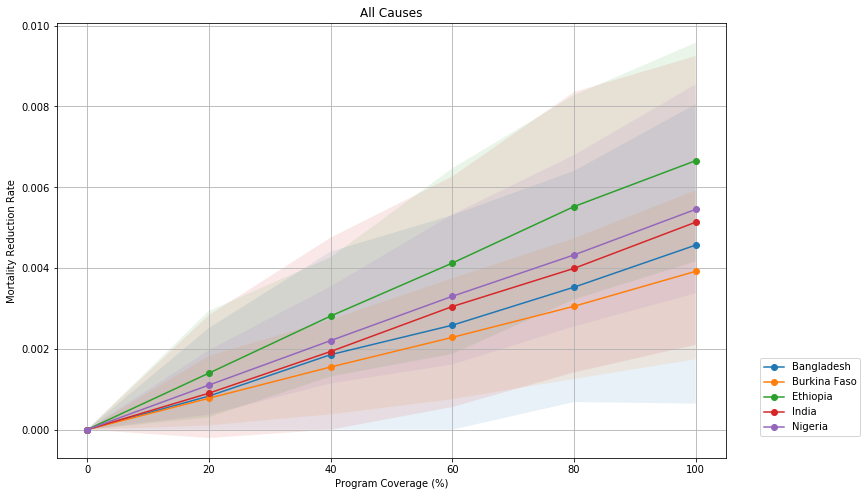

In [18]:
plot_all_causes_mortality_reduction(all_causes_mortality_reduction_rate)

# Anemia/Stunting/Wasting estimates

In [19]:
def get_year_from_template(template_string):
    return template_string.split('_in_')[1].split('_among_')[0]

def get_age_group_from_template(template_string):
    return template_string.split('_in_')[1].split('_among_')[1]

def get_risk_and_severity_from_template(template_string):
    s = template_string.split('_in_')[0].split('_')
    if 'anemia' in template_string:
        return s[0], s[1]
    else:
        return '_'.join(s[:2]), s[2]

In [20]:
def get_risk_percentage_points(my_dict):
    results = []
    cols = ['risk', 'year', 'age_group', 'coverage', 'input_draw']
    for location, path in my_dict.items():
        r = clean_and_aggregate(path)
        df = r[[c for c in r.columns if 'anemia' in c or 'child' in c]]
        df = df.stack().reset_index().rename(columns={'level_2': 'label', 0: 'value'})

        df['year'] = df.label.map(get_year_from_template)
        df['age_group'] = df.label.map(get_age_group_from_template)
        df['risk'] = df.label.map(lambda x: get_risk_and_severity_from_template(x)[0])
        df['severity'] = df.label.map(lambda x: get_risk_and_severity_from_template(x)[1])
        df.drop(columns='label', inplace=True)

        exposed = df.loc[~((df.severity == 'unexposed') | (df.severity == 'cat4') | (df.severity == 'cat3'))]
        exposed = exposed.groupby(cols)['value'].sum()
        total = df.groupby(cols)['value'].sum()
        percent_exposed = (exposed/total * 100).reset_index()
        percent_exposed['location'] = location
        
        results.append(percent_exposed)
    data = pd.concat(results)
    g = data.groupby(['location'] + cols[:-1])['value']
    g = g.describe(percentiles=[.025, .975]).filter(['mean', '2.5%', '97.5%'])
    
    return g.reset_index()

In [21]:
def plot_risk_percentage_points(df, risk):

    plt.figure(figsize=(12, 8))
    
    data = df.loc[(df.year == '2024') & (df.risk == risk)]
    
    for location in data.location.unique():
        data_sub = data.loc[data.location == location]
    
        xx = data_sub['coverage']
        mean = data_sub['mean']
        lb = data_sub['2.5%']
        ub = data_sub['97.5%']
                    
        plt.plot(xx, mean, '-o', label=location)
        plt.fill_between(xx, lb, ub, alpha=0.1)
    
    plt.title(f'{risk} percentage points in 2024')
    plt.xlabel('Program Coverage (%)')
    plt.ylabel(f'Under 5 % {risk}')
    plt.legend(loc=(1.05, .05))
    plt.grid()

    plt.savefig(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/sqlns_{risk}_percentage_points.pdf', bbox_inches='tight')
    plt.savefig(f'/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/sqlns_{risk}_percentage_points.png', bbox_inches='tight')

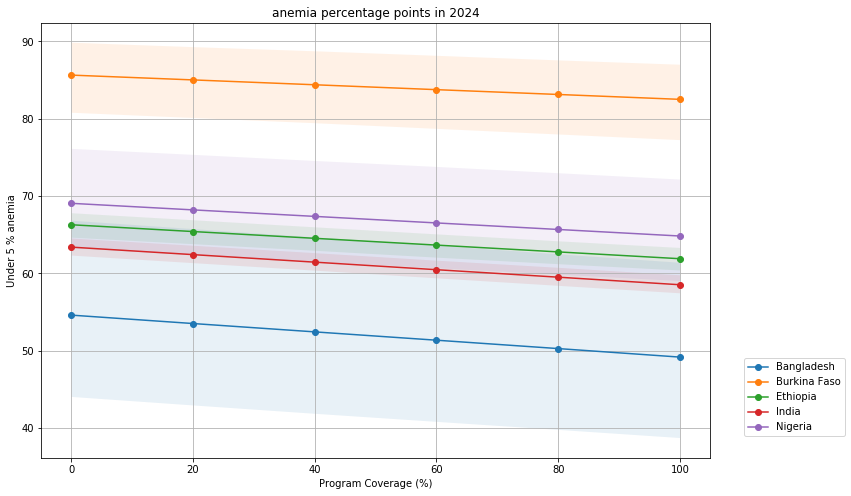

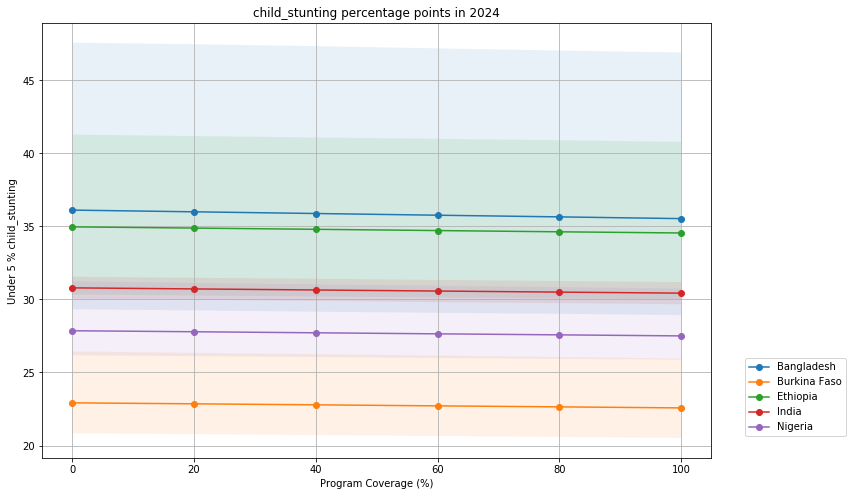

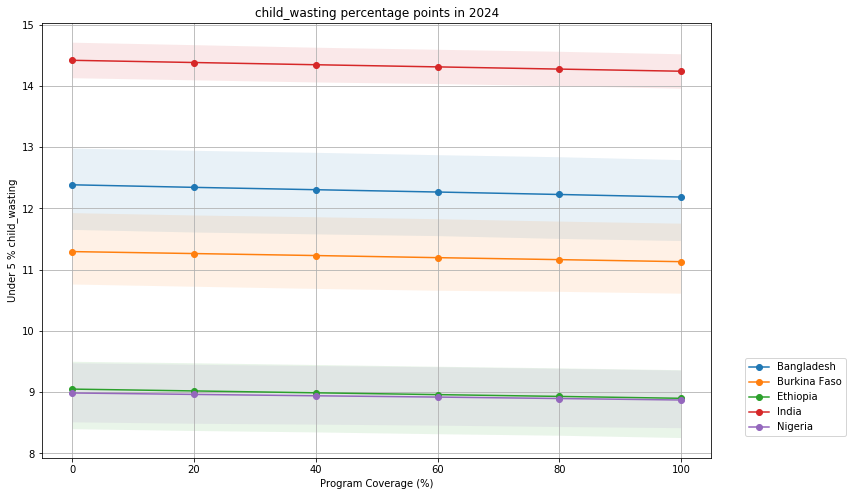

In [22]:
risk_percentage_points = get_risk_percentage_points(path_for_location)
for risk in risk_names:
    plot_risk_percentage_points(risk_percentage_points, risk)

In [23]:
risk_percentage_points.to_csv('/home/j/Project/simulation_science/mnch/Interventions/sq-lns/results/risk_percentage_points.csv', index=False)